# **Microplane Generic Verification**

This sheets shows the application of the microplane integration
on an example of VCoNTIM (vectorized implementation of the Coupled NT Interface Model.

## Ideal plasticity, uncoupled damage 

In [1]:
%matplotlib widget
from bmcs_matmod.msx import MSX
from bmcs_matmod.ntim import VCoNTIM, VUNTIM, ReturnMappingError
from bmcs_matmod.slide.slide_explorer import SlideExplorer
import matplotlib.pylab as plt
import numpy as np
np.seterr(divide='ignore', invalid='ignore');

In [2]:
mp_microplane1 = {
 'E_T': 1000,
 'gamma_T': 0,
 'K_T': 0,
 'S_T': 0.001,
 'c_T': 1,
 'bartau': 3,
 'E_N': 100,
 'S_N': 0.001,
 'c_N': 1,
 'm': 0.01,
 'f_t': 3,
 'f_c': 20,
 'f_c0': 10,
 'eta': 0.0}

In [3]:
mpl = MSX(E=34000, mic='contim', nu=0.18)
mpl.mic_.trait_set(debug=False, **mp_microplane1);
eps_max = mpl.eps_max
n_eps = 300
eps11_range = np.linspace(1e-9, 1, n_eps)
eps_range = np.zeros((n_eps, 3, 3))
eps_range[:, 0, 0] = eps11_range
state_vars = { 
    var: np.zeros((1,) + shape)
    for var, shape in mpl.state_var_shapes.items()
}
sig_range = []
for eps_ab in eps_range:
    try:
        sig_ab, D_range = mpl.get_corr_pred(eps_ab[np.newaxis,...], 1, **state_vars)
    except ReturnMappingError:
        break
    sig_range.append(sig_ab[0,...])

In [4]:
sig_range[-1]

array([[ 77.63105335,   0.        ,   0.        ],
       [  0.        , 160.53478354,   0.        ],
       [  0.        ,   0.        , 160.53478354]])

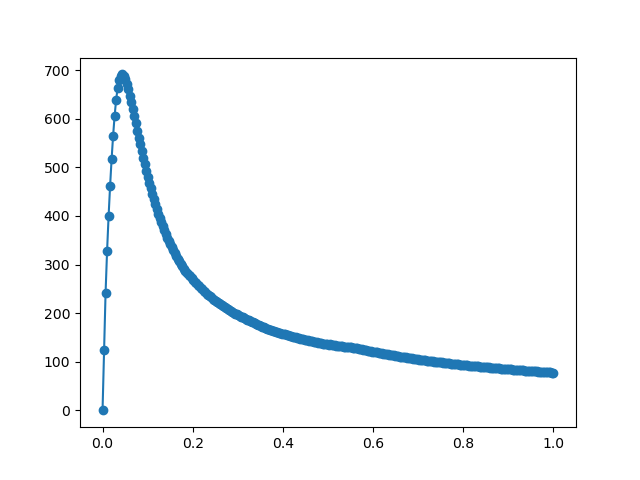

In [5]:
fig, ax = plt.subplots(1,1)
sig11_range = np.array(sig_range)
ax.plot(eps11_range[:len(sig11_range)], sig11_range[...,0,0], '-o')

## Realistic bulk stiffness, hardening and coupled brittle NT damage

In [7]:
mp_microplane = dict(K_T=300, gamma_T=3000, bartau=2, f_t=2, eta=1, 
                     c_T=0.1, S_T=0.00000001, c_N=3, S_N = 0.00000001 );

In [8]:
mpl = MSX(E = 28000, nu=0.22, eps_max=0.001)
mpl.mic_.trait_set(debug=False, **mp_microplane);
eps_max = mpl.eps_max
n_eps = 50
eps11_range = np.linspace(1e-9, eps_max, n_eps)
eps_range = np.zeros((n_eps, 3, 3))
eps_range[:, 0, 0] = eps11_range
state_vars = { 
    var: np.zeros((1,) + shape)
    for var, shape in mpl.state_var_shapes.items()
}

In [9]:
sig_range = []
for eps_ab in eps_range:
    sig_ab, D_range = mpl.get_corr_pred(eps_ab[np.newaxis,...], 1, **state_vars)
    sig_range.append(sig_ab[0,...])

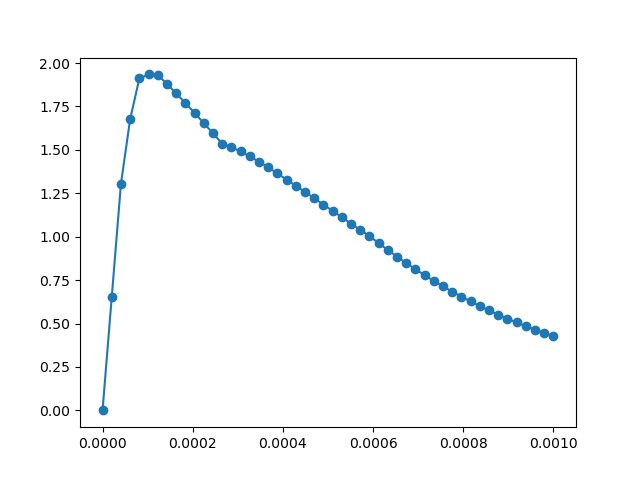

In [10]:
fig, ax = plt.subplots(1,1)
sig11_range = np.array(sig_range)
ax.plot(eps11_range[:len(sig11_range)], sig11_range[...,0,0], 'o-')

In [11]:
mpl.interact()

In [15]:
from ibvpy.api import XDomainSinglePoint, MATS3DScalarDamage, TStepBC, BCDof
xmodel = XDomainSinglePoint()
m = TStepBC(
    domains=[(xmodel, mpl),],
    bc=[BCDof(
            var='u', dof=0, value=0.001,
        )]
)
m.sim.tline.trait_set(step=0.01)
m.sim.reset()
m.sim.run()

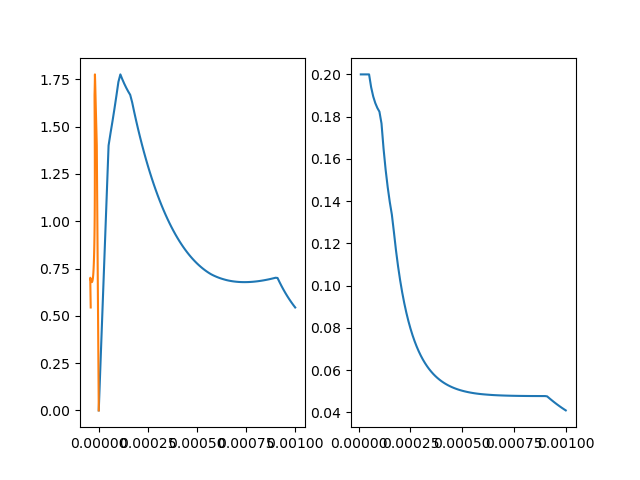

In [16]:
%matplotlib widget
import matplotlib.pylab as plt
_, (ax, ax_nu) = plt.subplots(1,2)
ax.plot(m.hist.U_t[:,0], m.hist.F_t[:,0])
ax.plot(m.hist.U_t[:,2], m.hist.F_t[:,0])
ax_nu.plot(m.hist.U_t[:,0], -m.hist.U_t[:,1] / m.hist.U_t[:,0])

## Application of interact method

In [3]:
%matplotlib widget
from bmcs_matmod.msx import MSX
import numpy as np
np.seterr(divide='ignore', invalid='ignore');

The example below demonstrate a case with ideally plastic response which delivers
several peaks in the response. At the same time, it can be used to demonstrate that 
$\nu \leq 0.25$ leads does not deliver any solution upon return mapping due to a square root overflow.

Once $E_\mathrm{T}$ becomes negative, the return mapping algorithm cannot work properly.
Is there some thermodynamically admissible interpretation of this case in the interface?
This can be posed in two questions:
 - is it posssible to obtain a positive dissipation of an interface even for negative
   value of $E_\mathrm{T}$?
 - if yes, is it allowed to reach an inelastic domain in the tangential direction?

In [5]:
mp_microplane = {
 'gamma_T': 1000,
 'K_T': 1000,
 'S_T': 0.000000001,
 'c_T': 1,
 'bartau': 3,
 'S_N': 0.000000001,
 'c_N': 1,
 'm': 0.01,
 'f_t': 3,
 'f_c': 20,
 'f_c0': 10,
 'eta': 1.0}
mpl = MSX(E = 28000, nu=0.2, eps_max=0.0001, n_eps=30, double_pvw=False)
mpl.mic_.trait_set(debug=False, **mp_microplane);
mpl.interact()